## 交易策略

在特定的预期条件达成时一个**开放头寸**会被关闭。**多头**头寸表示交易中需要金融商品价格上升才能产生盈利，**空头**头寸表示交易中需要金融商品价格下降才能产生盈利。在股票交易中，多头头寸是牛市，空头头寸是熊市，反之则不成立。（股票期权交易中这个非常典型）

例如你在预计股价上涨的情况下购入股票，并计划在股票价格上涨高于购入价时抛出，这就是多头头寸。就是说你持有一定的金融产品，如果它们价格上涨，你将会获利，并且没有上限；如果它们价格下降，你会亏损。由于股票价格不会为负，亏损是有限度的。相反的，如果你预计股价会下跌，就从交易公司借贷股票然后卖出，同时期待未来股票价格下降后再低价买入还贷来赚取差额，这就是**空头股票**。如果股价下跌你会获利。空头头寸的获利额度受股价所限（最佳情况就是股票变得一文不值，你不用花钱就能将它们买回来），而损失却没有下限，因为你有可能需要花很多钱才能买回股票。所以交换所只会在确定投资者有很好的经济基础的情况下才会让他们空头借贷股票。

所有股民都应该决定他在每一股上可以冒多大的风险。比如有人决定无论什么情况他都不会在某一次交易中投入总额的10%去冒险。同时在交易中，股民要有一个**撤出策略**，这是让股民退出头寸的各种条件。股民也可以设置一个目标，这是导致股民退出头寸的最小盈利额。同样的，股民也需要有一个他能承受的最大损失额度。当预计损失大于可承受额度时，股民应该退出头寸以避免更大损失（这可以通过设置**停止损失委托**来避免未来的损失）。

我们要设计一个**交易策略**，它包含用于快速交易的交易激发信号、决定交易额度的规则和完整的退出策略。我们的目标是设计并评估该交易策略。

假设每次交易金额占总额的比例是固定的（10%）。同时设定在每一次交易中，如果损失超过了20%的交易值，我们就退出头寸。现在我们要决定什么时候进入头寸，什么时候退出以保证盈利。

这里我要演示[移动平均交汇点分析移动平均线的方法](http://www.investopedia.com/university/movingaverage/movingaverages4.asp)。我会使用两条移动平均线，一条快速的，另一条是慢速的。我们的策略是：

- 当快速移动平均线和慢速移动线交汇时开始交易
- 当快速移动平均线和慢速移动线再次交汇时停止交易

做多是指在快速平均线上升到慢速平均线之上时开始交易，当快速平均线下降到慢速平均线之下时停止交易。卖空正好相反，它是指在快速平均线下降到慢速平均线之下时开始交易，快速平均线上升到慢速平均线之上时停止交易。

现在我们有一整套策略了。在使用它之前我们需要先做一下测试。回溯测试是一个常用的测试方法，它使用历史数据来看策略是否会盈利。例如这张苹果公司的股票价值图，如果20天的移动平均是快速线，50天的移动平均是慢速线，那么我们这个策略不是很挣钱，至少在你一直做多头头寸的时候。

下面让我们来自动化回溯测试的过程。首先我们要识别什么时候20天平均线在50天之下，以及之上。

In [122]:
import pandas as pd
import pandas_datareader as pdr
import datetime

# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = pdr.get_data_yahoo("AAPL", start, end)

In [123]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["open", "high", "low", "close"]]
    #transdat.index = dat['date']
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"open": [], "high": [], "low": [], "close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"open": group.iloc[0,0],
                                            "high": max(group.high),
                                            "low": min(group.low),
                                            "close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"open": [], "high": [], "low": [], "close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"open": group.iloc[0,0],
                                        "high": max(group.high),
                                        "low": min(group.low),
                                        "close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(mdates.date2num(plotdat.index.tolist())), plotdat["open"].tolist(), plotdat["high"].tolist(),
                      plotdat["low"].tolist(), plotdat["close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [124]:
import numpy as np
apple["20d"] = np.round(apple["close"].rolling(window = 20, center = False).mean(), 2)
apple["50d"] = np.round(apple["close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["close"].rolling(window = 200, center = False).mean(), 2)
apple['20d-50d'] =apple['20d'] - apple['50d']
apple['50d-20d'] =apple['50d'] - apple['20d']
apple.index = apple['date']
apple.tail()

#import datetime as dt
#pandas_candlestick_ohlc(apple.loc[dt.date(2016,8,7):dt.date(2016,1,4),:], otherseries = "20d")

,date,high,low,open,close,volume,adjclose,20d,50d,200d,20d-50d,50d-20d
date,,,,,,,,,,,,
2016-01-07,2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,92.480476,97.26,98.29,102.64,-1.03,1.03
2016-01-06,2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,96.555573,97.47,98.18,102.55,-0.71,0.71
2016-01-05,2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,98.482841,97.79,98.12,102.48,-0.33,0.33
2016-01-04,2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,101.014183,98.33,98.11,102.42,0.22,-0.22
2015-12-31,2015-12-31,107.029999,104.820000,107.010002,105.260002,40635300.0,100.927895,98.77,98.12,102.36,0.65,-0.65


我们将差异的符号称为**状态转换**。快速移动平均线在慢速移动平均线之上代表牛市状态；相反则为熊市。以下的代码用于识别状态转换。

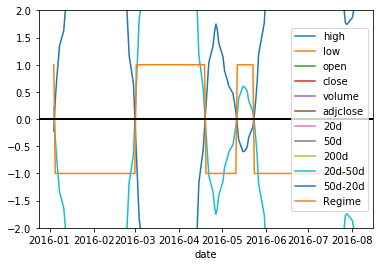

In [125]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc[dt.date(2016,8,7):dt.date(2016,1,1),:].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

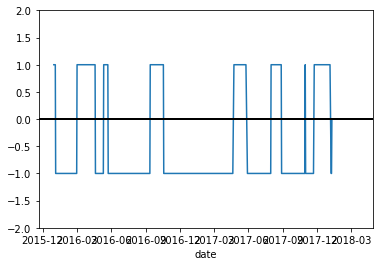

In [126]:
apple["Regime"].plot(ylim =(-2,2)).axhline(y =0, color ="black", lw =2)

In [127]:
apple["Regime"].value_counts()

-1    365
 1    145
 0     49
Name: Regime, dtype: int64

从上面的曲线可以看到有966天苹果公司的股票是牛市，663天是熊市，有54天没有倾向性。（原文中牛市和熊市说反了，译文中更正；原文数字跟代码结果对不上，译文按照代码结果更正）

交易信号出现在状态转换之时。牛市出现时，买入信号被激活；牛市完结时，卖出信号被激活。同样的，熊市出现时卖出信号被激活，熊市结束时，买入信号被激活。（只有在你空头股票，或者使用一些其他的方法例如用股票期权赌市场的时候这种情况才对你有利）

![](http://wx3.sinaimg.cn/mw690/6941baebly1firhjs7w2xj20kl033mx4.jpg)

In [128]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

/Users/jing/.virtualenvs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,date,high,low,open,close,volume,adjclose,20d,50d,200d,20d-50d,50d-20d,Regime,Signal
date,,,,,,,,,,,,,,
2016-01-07,2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,92.480476,97.26,98.29,102.64,-1.03,1.03,-1,0.0
2016-01-06,2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,96.555573,97.47,98.18,102.55,-0.71,0.71,-1,0.0
2016-01-05,2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,98.482841,97.79,98.12,102.48,-0.33,0.33,-1,0.0
2016-01-04,2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,101.014183,98.33,98.11,102.42,0.22,-0.22,1,1.0
2015-12-31,2015-12-31,107.029999,104.820000,107.010002,105.260002,40635300.0,100.927895,98.77,98.12,102.36,0.65,-0.65,1,-1.0


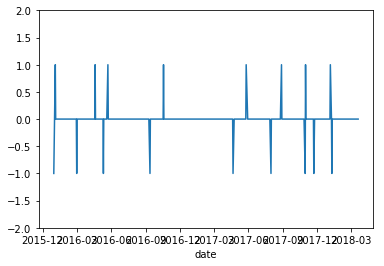

In [129]:
apple["Signal"].plot(ylim =(-2, 2))

In [130]:
apple["Signal"].value_counts()

 0.0    541
-1.0      9
 1.0      8
Name: Signal, dtype: int64

我们会买入苹果公司的股票20次，抛出21次 （原文数字跟代码结果不符，译文根据代码结果更正）。如果我们只选了苹果公司的股票，六年内只有21次交易发生。如果每次多头转空头的时候我们都采取行动，我们将会参与21次交易。（请记住交易次数不是越多越好，毕竟交易不是免费的）

你也许注意到了这个系统不是很稳定。快速平均线在慢速平均线之上就激发交易，即使这个状态只是短短一瞬，这样会导致交易马上终止（这样并不好因为现实中每次交易都要付费，这个费用会很快消耗掉收益）。同时所有的牛市瞬间转为熊市，如果你允许同时押熊市和牛市，那就会出现每次交易结束就自动激发另一场押相反方向交易的诡异情况。更好的系统会要求有更多的证据来证明市场的发展方向，但是这里我们不去追究那个细节。

下面我们来看看每次买入卖出时候的股票价格。

In [131]:
apple.loc[apple["Signal"] == 1, "close"]

date
2018-01-05    175.000000
2017-10-31    169.039993
2017-08-28    161.470001
2017-05-26    153.610001
2016-10-18    117.470001
2016-05-23     96.430000
2016-04-19    106.910004
2016-01-04    105.349998
Name: close, dtype: float64

In [132]:
apple.loc[apple["Signal"] == -1, "close"]

date
2018-01-09    174.330002
2017-11-22    174.960007
2017-10-30    166.720001
2017-07-31    148.729996
2017-04-21    142.270004
2016-09-12    105.440002
2016-05-11     92.510002
2016-03-01    100.529999
2015-12-31    105.260002
Name: close, dtype: float64

In [133]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
date,,,
2015-12-31,105.260002,1,Sell
2016-01-04,105.349998,1,Buy
2016-03-01,100.529999,-1,Sell
2016-04-19,106.910004,1,Buy
2016-05-11,92.510002,-1,Sell
2016-05-23,96.430000,1,Buy
2016-09-12,105.440002,-1,Sell
2016-10-18,117.470001,1,Buy
2017-04-21,142.270004,-1,Sell


In [134]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
date,,,
2016-01-04,2016-03-01,105.349998,-4.820000
2016-04-19,2016-05-11,106.910004,-14.400002
2016-05-23,2016-09-12,96.430000,9.010002
2016-10-18,2017-04-21,117.470001,24.800003
2017-05-26,2017-07-31,153.610001,-4.880005
2017-08-28,2017-10-30,161.470001,5.250000
2017-10-31,2017-11-22,169.039993,5.920013
2018-01-05,2018-01-09,175.000000,-0.669998


从上表可以看出2013年5月17日那天苹果公司股票价格大跌，我们的系统会表现很差。但是那个价格下降不是因为苹果遇到了什么大危机，而仅仅是一次分股。由于分红不如分股那么显著，这也许会影响系统行为。

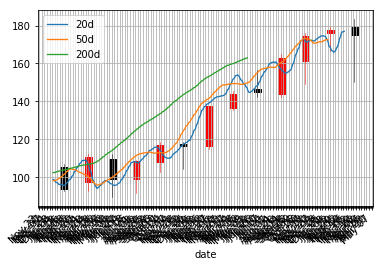

In [135]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

我们不希望我们的交易系统的表现受到分红和分股的影响。一个解决方案是利用历史的分红分股数据来设计交易系统，这些数据可以真实地反映股市的行为从而帮助我们找到最佳解决方案，但是这个方法要更复杂一些。另一个方案就是根据分红和分股来调整股票的价格。

雅虎财经只提供调整之后的股票闭市价格，不过这些对于我们调整开市，高价和低价已经足够了。调整闭市股价是这样实现的：

![](http://wx4.sinaimg.cn/mw690/6941baebly1firhnaoet0j20m0027t8n.jpg)

让我们回到开始，先调整股票价格，然后再来评价我们的交易系统。

/Users/jing/.virtualenvs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


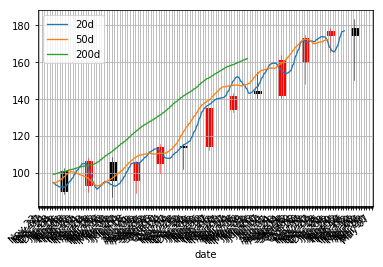

In [136]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"open": dat["open"] * dat["adjclose"] / dat["close"],
                       "high": dat["high"] * dat["adjclose"] / dat["close"],
                       "low": dat["low"] * dat["adjclose"] / dat["close"],
                       "close": dat["adjclose"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [137]:
apple_adj_long_profits

,End Date,Price,Profit
date,,,
2015-12-31,2016-03-01,100.927895,-4.012291
2016-04-18,2016-05-11,103.615730,-13.888779
2016-05-23,2016-09-13,93.529015,11.740639
2016-10-17,2017-04-21,114.631294,25.423134
2017-05-26,2017-07-31,151.841980,-4.823837
2017-08-28,2017-11-22,160.238312,14.011261
2018-01-05,2018-01-09,174.289398,-0.667282


可以看到根据分红和分股调整之后的价格图变得很不一样了。之后的分析我们都会用到这个调整之后的数据。

假设我们在股市有一百万，让我们来看看根据下面的条件，我们的系统会如何反应：

- 每次用总额的10%来进行交易
- 退出头寸如果亏损达到了交易额的20%

模拟的时候要记住：

- 每次交易有100支股票
- 我们的避损规则是当股票价格下降到一定数值时就抛出。我们需要检查这段时间内的低价是否低到可以出发避损规则。现实中除非我们买入看空期权，我们无法保证我们能以设定低值价格卖出股票。这里为了简洁我们将设定值作为卖出值。
- 每次交易都会付给中介一定的佣金。这里我们没有考虑这个。

下面的代码演示了如何实现回溯测试：